# Set up plates for a duckweed genotypes x media growth assay

## 0. Import packages and libraries

In [1]:
import pandas as pd
import os
import json
import time
import ipywidgets as widgets

def search_up_dirs(target_dir, max_cycles):
    n = 0
    while n != max_cycles:
        curr_folder = os.path.basename(os.path.normpath(os.getcwd()))
        if curr_folder == target_dir:
            break
        os.chdir('..')
        n = n + 1
        
search_up_dirs('duckbot', 5) #Shift to duckbot
os.chdir('notebooks')

import utils.PlatePositionUtils as pp 
import utils.DuckbotExptSetupUtils as exp


In [2]:
#This cell will only run if you are working at a computer connected to the Jubilee
from utils.CameraUtils import *
from utils.MachineUtils import *
port = "/dev/ttyACM0"
m = MachineCommunication(port)

## 1. Select config files

### Select  Hadware-Labware config file

In [3]:
search_up_dirs('duckbot', 5) #Shift to duckbot
os.chdir('ConfigFiles')
labware_config_file_dir = os.path.join(os.getcwd(),'HardwareLabwareConfigs')
os.chdir(labware_config_file_dir)
config_opts = os.listdir(os.getcwd())
hl_choice = widgets.Dropdown(options = config_opts)
display(hl_choice)

Dropdown(options=('camera_cal.json', 'Default.json'), value='camera_cal.json')

In [4]:
with open(hl_choice.value,'r') as datafile:
    hardwarelabwareconfig = json.load(datafile)
media_reservoir = hardwarelabwareconfig['media_reservoir']
tool_positions = hardwarelabwareconfig['tool_positions']
dispense_calcs = hardwarelabwareconfig['dispense_calcs']
media_dispensing_z_dict = hardwarelabwareconfig['media_dispensing_z_dict']
inoculation_loop_z_dict = hardwarelabwareconfig['inoculation_loop_z_dict']
rightangle_inoculation_loop_z_dict = hardwarelabwareconfig['rightangle_inoculation_loop_z_dict']
dispense_offset =  dispense_calcs['dispense_mL'] * dispense_calcs['vol_conversion']
dispenses_per_syringe_fill = dispense_calcs['dispenses_per_syringe_fill']
duckweed_reservoir_loc = hardwarelabwareconfig["duckweed_reservoir_loc"]

In [5]:
inoculation_loop_z_dict

{'collect': -16.5, 'move': 14, 'transfer': -15.0}

### Select experimental config file

In [6]:
search_up_dirs('duckbot', 5) #Shift to duckbot
os.chdir('ConfigFiles')
expt_config_file_dir = os.path.join(os.getcwd(),'ExptConfigs')
os.chdir(expt_config_file_dir)
config_opts = os.listdir(os.getcwd())
expt_choice = widgets.Dropdown(options = config_opts)
display(expt_choice)

Dropdown(options=('Test_082422_2.json', 'Test_082422_3.json', 'Figure5Experiment.json', 'Test_082422.json', 'F…

In [7]:
print(f"You selected: *{expt_choice.value}*")
print("If this is not correct re-select before continuing")

You selected: *FrondTransferForRootImaging.json*
If this is not correct re-select before continuing


In [8]:
expt_setup_filepath = expt_config_file_dir + '/' + expt_choice.value

### Visualize and confirm plate set up

#### Run this cell to print a visualization of your experimental design. If this isn't as expected go back and re-run the config file selection cell or go back and directly edit your experimental config file and start again

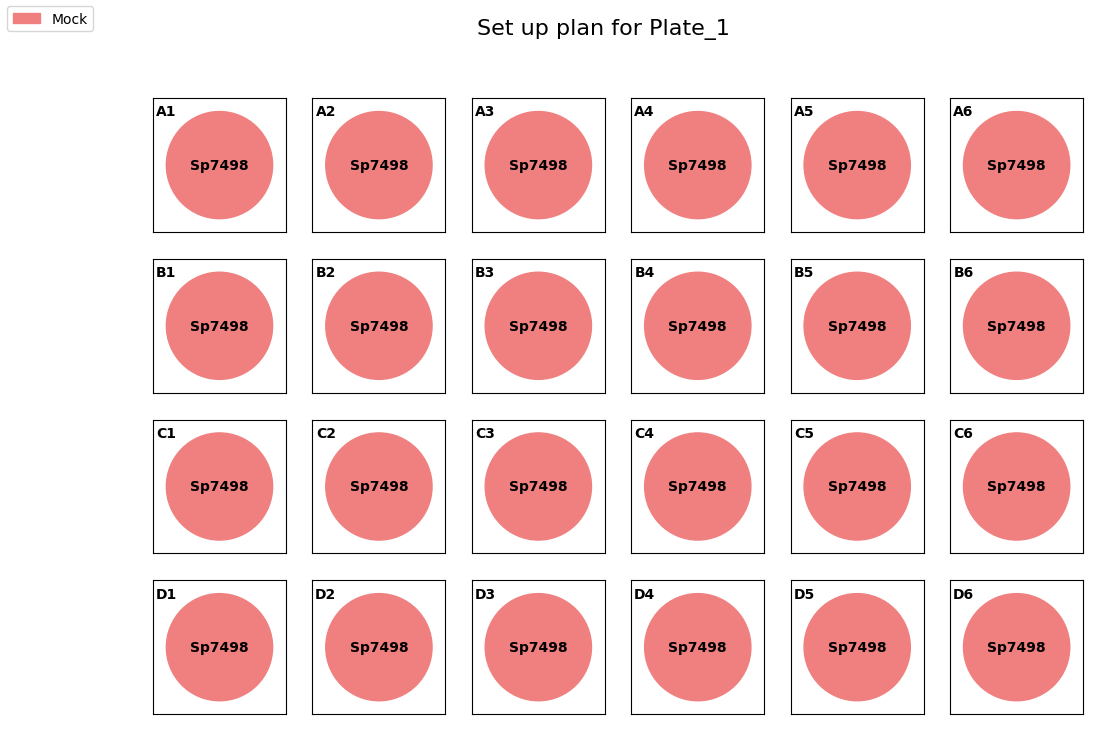

In [9]:
%matplotlib inline
with open(expt_setup_filepath,'r') as datafile:
    expt_data = json.load(datafile)
    
sample_data_dict = expt_data["sample_info"] # Turn samples list into a dataframe

df_with_well_coords = pp.add_well_coords_to_df_from_sample_data_dict(sample_data_dict)
exp.visualize_plate_set_up(df_with_well_coords)

## 2. Label 24-well plates and add to machine
Follow the instructions that are printed when you run the cells

#### Label Plates and add plates to machine

In [10]:
df = pd.DataFrame(sample_data_dict)
num_plates = df.Plate.nunique()
print(num_plates)

print("This experiment requires {} 24-well plate(s)".format(num_plates))
print("----")
lst = list(range(1,num_plates + 1))
for n in lst:
    print("Label a plate with experiment ID or initials and 'plate {}'".format(n))
print("----")
print ("Place the 24-well plate(s) in the jubilee".format(num_plates))
print ("Start at position 1 and fill empty plate slots in order")

1
This experiment requires 1 24-well plate(s)
----
Label a plate with experiment ID or initials and 'plate 1'
----
Place the 24-well plate(s) in the jubilee
Start at position 1 and fill empty plate slots in order


## 3. Dispense media
Run cells, making sure to follow the instructions that print when your run the cells

In [11]:
#Retrieve absolute positions of wells from a library and then add those coordinatest to the plate set up dataframe
df_with_well_coords = pp.add_well_coords_to_df_from_sample_data_dict(sample_data_dict)
    
#Reorganizes dataframe to create machine instructions sorted by media-type
media_dicts = pp.pull_list_of_well_coord_dicts_by_dfcolumn(df_with_well_coords, 'media')

In [13]:
#Pick up syringe toolhead
media_syringe = tool_positions['media_syringe']
m.toolChange(media_syringe)

In [14]:
# Send machine instructions
for media in media_dicts:
    m.moveTo(x=0,y=0,z=25)
    print(f"Please ensure {media['media']} is available in the machine before continuing.")
    print("Change syringe and/or needle if desired")
    while True:
        value = input("Enter 'YES' to confirm that the correct media is in position")
        if value != "YES":
            print("Please confirm")
        else:
            break
    exp.dispense_to_wells(m, media["well-coords"], dispense_offset, dispenses_per_syringe_fill, media_reservoir, media_dispensing_z_dict)

Please ensure Mock is available in the machine before continuing.
Change syringe and/or needle if desired
Enter 'YES' to confirm that the correct media is in positionYES
Dispensing media, please wait
Dispensing media, please wait
Media dispensing completed


## 4. Transfer duckweed

### Transfer option 1: Automated transfer with inoculation loop

In [12]:
#pop the bed down to avoid any collisions on tool change
m.moveTo(z=50)

In [13]:
# pick up the innoculation loop
inoculation_loop = tool_positions['inoculation_loop']
m.toolChange(inoculation_loop)
m.moveTo(x=duckweed_reservoir_loc[0], y=duckweed_reservoir_loc[1])

In [14]:
# pop the bed down to avoid collisions after probing 
m.moveTo(z=50)

### Change the next cell for right angle vs standard inoculation loop!

In [ ]:
# Inoculation Loop Transfer
# The machine will move after running this cell
exp.inoculation_loop_transfer(m, df, duckweed_reservoir_loc, inoculation_loop_z_dict)

Place container of duckweed type **Lm5500** into jubilee and ensure lid is open
Type anything into the input field to confirm that the duckweed is available.
        After this point the Jubilee will begin transferring
y
Place container of duckweed type **Lm8627** into jubilee and ensure lid is open
Type anything into the input field to confirm that the duckweed is available.
        After this point the Jubilee will begin transferring
y
Place container of duckweed type **Sp7498** into jubilee and ensure lid is open
Type anything into the input field to confirm that the duckweed is available.
        After this point the Jubilee will begin transferring
y
Place container of duckweed type **Wa7788** into jubilee and ensure lid is open
Type anything into the input field to confirm that the duckweed is available.
        After this point the Jubilee will begin transferring


In [ ]:
# pop bed down to access labware
m.moveTo(z=100)

### Consecutive Tranfser Passes
These cells will find any wells missing duckweed, and then prompt you to swap in the appropriate duckweed reservoir for transfer. Re-run the cells as many times as you like until you are satisfied with the results

In [12]:
m.toolChange(3)
exp.check_wells(m, df_with_well_coords)

Checking well A1
Checking well A2
Checking well A3
Checking well A4
Checking well A5
Checking well A6
Checking well B1
Checking well B2
Checking well B3
Checking well B4
Checking well B5
Checking well B6
Checking well C1
Well C1 needs fronds
Checking well C2
Checking well C3
Checking well C4
Well C4 needs fronds
Checking well C5
Well C5 needs fronds
Checking well C6
Checking well D1
Checking well D2
Checking well D3
Checking well D4
Checking well D5
Checking well D6
Checking well A1
Well A1 needs fronds
Checking well A2
Checking well A3
Well A3 needs fronds
Checking well A4
Checking well A5
Checking well A6
Well A6 needs fronds
Checking well B1
Checking well B2
Well B2 needs fronds
Checking well B3
Checking well B4
Checking well B5
Checking well B6
Checking well C1
Checking well C2
Checking well C3
Checking well C4
Well C4 needs fronds
Checking well C5
Well C5 needs fronds
Checking well C6
Checking well D1
Checking well D2
Well D2 needs fronds
Checking well D3
Checking well D4
Checking

In [ ]:
# debug cells
f = getFrame()
showFrame(f)

In [ ]:
f = getFrame()
frame, wellData = getSingleWell(f, minR=350, maxR=500)
showFrame(frame)
# crop, crop_data = exp.well_check_circle_crop(f)
# showFrame(crop)


In [ ]:
frond_check = exp.identify_fronds(crop)
print(frond_check)

### change next cell based on right angle or standard inoculation loop!

In [12]:
exp.fill_empty_wells(m, df_with_well_coords, duckweed_reservoir_loc, inoculation_loop_z_dict)

Place container of duckweed type **Lm5500** into jubilee and ensure lid is open
Type anything into the input field to confirm that the duckweed is available.
        After this point the Jubilee will begin transferring
y


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/pi/duckbot/.venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1990/2272356037.py", line 1, in <module>
    exp.fill_empty_wells(m, df_with_well_coords, duckweed_reservoir_loc, inoculation_loop_z_dict)
  File "/home/pi/duckbot/notebooks/utils/DuckbotExptSetupUtils.py", line 284, in fill_empty_wells
    inoculation_loop_transfer(m, empty, duckweed_reservoir, z_dict)
  File "/home/pi/duckbot/notebooks/utils/DuckbotExptSetupUtils.py", line 136, in inoculation_loop_transfer
    m.move(dy=-5, s=100) # move in opposite direction
  File "/home/pi/duckbot/notebooks/utils/MachineUtils.py", line 112, in move
    self.setAbsolute() # restore absolute positioning
  File "/home/pi/duckbot/notebooks/utils/MachineUtils.py", line 145, in setAbsolute
    self.send(cmd)
  File "/home/pi/duckbot/notebooks/utils/MachineUtils.py", line 24, in 

TypeError: object of type 'NoneType' has no len()

### Transfer option 2: Manual transfer
Run this cell to generate written instructions of what duckweed genotypes should be in which wells. 

In [ ]:
#Manual transfer

grouped_df = df.groupby('genotype')
for field_value, sample_df in grouped_df:
    print("Place container of duckweed type **{0}** into jubilee and ensure lid is open".format(field_value))
    for index,s in sample_df.iterrows():
        plate = s["Plate"]
        well = s["Well"]
        print(f"Transfer {field_value} to plate {plate}, well {well}")
    input()
        #print("Dispensing media of type {0} into {1}, well {2}".format(field_value,s["Plate"], s["Well"]))


Place container of duckweed type **Lm5500** into jubilee and ensure lid is open
Transfer Lm5500 to plate Plate_1, well A1
Transfer Lm5500 to plate Plate_1, well A2
Transfer Lm5500 to plate Plate_1, well A6
Transfer Lm5500 to plate Plate_1, well B6
Transfer Lm5500 to plate Plate_1, well C6
Transfer Lm5500 to plate Plate_2, well A1
Transfer Lm5500 to plate Plate_2, well A4
Transfer Lm5500 to plate Plate_2, well B1
Transfer Lm5500 to plate Plate_2, well B2
Transfer Lm5500 to plate Plate_2, well D2
Transfer Lm5500 to plate Plate_2, well D5
Transfer Lm5500 to plate Plate_2, well D6
Transfer Lm5500 to plate Plate_3, well A1
Transfer Lm5500 to plate Plate_3, well B3
Transfer Lm5500 to plate Plate_3, well B6
Transfer Lm5500 to plate Plate_3, well C2
y
Place container of duckweed type **Lm8627** into jubilee and ensure lid is open
Transfer Lm8627 to plate Plate_1, well B3
Transfer Lm8627 to plate Plate_1, well C1
Transfer Lm8627 to plate Plate_1, well C4
Transfer Lm8627 to plate Plate_1, well C

#### Record any extra notes you'd like to add
Write down any notes about today's set up that you would like to be recorded in the set up file 

In [ ]:
notes = input()
exp.add_input_to_json(notes, "Set_up_notes", expt_setup_filepath)

In [ ]:
## Syringe Transfer

In [ ]:
# pop the bed down to avoid collisions
m.moveTo(z=50)
# pick up the syringe
m.toolChange(3)
m.moveTo(x=duckweed_reservoir_loc[0], y=duckweed_reservoir_loc[1])

# syringe offset changes based on height
# need to look into this
syringe_zero = -24 # z position where pink syringe tip touches bed plate. used for refining camera alignment 
syringe_off = [-0.76, 4.2] # pink syringe tip for picture height of 80

reservoir_height = -9.4

In [ ]:
m.moveTo(z=50) # pop bed down after probing

In [ ]:
# loads in the relevant calibration files

with open("/home/pi/autofocus-test/JubileeAutofocus/camera_cal_z_80.json") as f:
    cal = json.load(f)
matrix = np.array(cal['transform'])
size = cal['resolution']
print(matrix)
print(size)

m.transform = matrix
m.img_size = size

In [ ]:
# convert px coord to real coord
def px_to_real(x,y, absolute = False):
        x = (x / m.img_size[0]) - 0.5
        y = (y / m.img_size[1]) - 0.5
        a = 1 if absolute else 0

        return (m.transform.T @ np.array([x**2, y**2, x * y, x, y, a]))


In [ ]:
m.moveTo(z=80) # change depending on imaging eight
m.toolChange(1)
m.moveTo(x=duckweed_reservoir_loc[0], y=duckweed_reservoir_loc[1])
water_depth = syringe_zero - reservoir_height
print(water_depth)

In [ ]:
# move machine if the above looks reasonable
m.move(dz=water_depth)

In [ ]:
#focus camera
cap = cv2.VideoCapture(0) #Note that the index corresponding to your camera may not be zero but this is the most common default

# draw a circle in the center of the frame
center = None
while center is None:
    # the first frame grab is sometimes empty
    ret, frame = cap.read()
    h, w = frame.shape[0:2]
    center = (int(w/2), int(h/2))
    print(center)

while True:
    ret, frame = cap.read()
    target = cv2.circle(frame, center, 5, (0,255,0), -1)
    cv2.imshow('Input', frame)
    c = cv2.waitKey(1)
    if c ==27: #27 is the built in code for ESC so press escape to close the window. 
        break 
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
%matplotlib auto
f = getFrame()
pts = selectPoint(f, num_pts=5)

In [ ]:
fronds = []
for pt in pts:
    frond_off = px_to_real(pt[0], pt[1])
    frond = [duckweed_reservoir_loc[0] - frond_off[0], duckweed_reservoir_loc[1] - frond_off[1]]
    fronds.append(frond)

In [ ]:
fronds

In [ ]:
def aspirate_2(h):
#     m.move(de=5, s=1000) ; # 'prime' syringe
    m.moveTo(z=h + 2)
    m.dwell(1000)
    m.move(dz=-3.5, de=5) # press slightly
#     m.dwell(250)
    m.move(de=40, s=1800) # aspirate! #1200 for lemna minor
    m.move(dz=6, s=500, de=5) # aspirate!
#     m.move(dz=5, de=50, s=1000) # aspirate!

In [ ]:
m.toolChange(3)
grouped_df = df.groupby('genotype')
idx = 0
for field_value, sample_df in grouped_df:
#     print("Place container of duckweed type **{0}** into jubilee and ensure lid is open".format(field_value))
    for index,s in sample_df.iterrows():
        plate = s["Plate"]
        wellId = s["Well"]
        well = pp.fetch_well_position(1, str(wellId))
    
        
        fx = fronds[idx][0]
        fy = fronds[idx][1]
        m.moveTo(m.moveTo(x=fx + syringe_off[0], y=fy + syringe_off[1]))
        aspirate_2(reservoir_height)
        m.moveTo(z=7)
        m.moveTo(x=well['x'], y=well['y'])
        m.move(de=-47, s=1000)
        
        idx += 1
        
        



In [ ]:
m.toolChange(1)
exp.check_wells(m, df_with_well_coords)

In [ ]:
#get the height & pics again

In [ ]:
m.moveTo(z=50)
m.toolChange(3)
empty = df_with_well_coords.loc[df_with_well_coords['hasFronds'] == False]
grouped_df = empty.groupby('genotype')
idx = 0
for field_value, sample_df in grouped_df:
#     print("Place container of duckweed type **{0}** into jubilee and ensure lid is open".format(field_value))
    for index,s in sample_df.iterrows():
        plate = s["Plate"]
        wellId = s["Well"]
        well = pp.fetch_well_position(1, str(wellId))
    
        
        fx = fronds[idx][0]
        fy = fronds[idx][1]
        m.moveTo(m.moveTo(x=fx + syringe_off[0], y=fy + syringe_off[1]))
        aspirate_2(reservoir_height)
        m.moveTo(z=7)
        m.moveTo(x=well['x'], y=well['y'])
        m.move(de=-47, s=1000)
        
        idx += 1
        
        

